In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import warnings
warnings.filterwarnings('ignore')

Библиотеки загружены!
TensorFlow version: 2.19.0


In [ ]:
!pip install ucimlrepo

from ucimlrepo import fetch_ucirepo

cardiotocography = fetch_ucirepo(id=193)

X = cardiotocography.data.features
y = cardiotocography.data.targets

print("Информация о датасете:")
print(cardiotocography.metadata)
print("\nПеременные:")
print(cardiotocography.variables)

print(f"\nРазмерность признаков (X): {X.shape}")
print(f"Размерность целевой переменной (y): {y.shape}")
print(f"\nНазвания признаков: {list(X.columns)}")
print(f"Название целевой переменной: {list(y.columns)}")

Информация о датасете:
{'uci_id': 193, 'name': 'Cardiotocography', 'repository_url': 'https://archive.ics.uci.edu/dataset/193/cardiotocography', 'data_url': 'https://archive.ics.uci.edu/static/public/193/data.csv', 'abstract': 'The dataset consists of measurements of fetal heart rate (FHR) and uterine contraction (UC) features on cardiotocograms classified by expert obstetricians.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 2126, 'num_features': 21, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['CLASS', 'NSP'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2000, 'last_updated': 'Fri Mar 15 2024', 'dataset_doi': '10.24432/C51S4N', 'creators': ['D. Campos', 'J. Bernardes'], 'intro_paper': None, 'additional_info': {'summary': '2126 fetal cardiotocograms (CTGs) were automatically processed and the respective diagnostic features measured. The CT

In [ ]:
print("Первые 5 строк признаков:")
print(X.head())

print("\nПервые 5 строк целевой переменной:")
print(y.head())

print(f"\nПропущенные значения в X: {X.isnull().sum().sum()}")
print(f"Пропущенные значения в y: {y.isnull().sum().sum()}")

X_clean = X.dropna()
y_clean = y.loc[X_clean.index]

y_nsp = y_clean['NSP']

print(f"\nПосле очистки:")
print(f"X_clean shape: {X_clean.shape}")
print(f"y_nsp shape: {y_nsp.shape}")
print("\nРаспределение классов NSP:")
print(y_nsp.value_counts().sort_index())

Первые 5 строк признаков:
    LB     AC   FM     UC     DL   DS   DP  ASTV  MSTV  ALTV  ...  Width  Min  \
0  120  0.000  0.0  0.000  0.000  0.0  0.0    73   0.5    43  ...     64   62   
1  132  0.006  0.0  0.006  0.003  0.0  0.0    17   2.1     0  ...    130   68   
2  133  0.003  0.0  0.008  0.003  0.0  0.0    16   2.1     0  ...    130   68   
3  134  0.003  0.0  0.008  0.003  0.0  0.0    16   2.4     0  ...    117   53   
4  132  0.007  0.0  0.008  0.000  0.0  0.0    16   2.4     0  ...    117   53   

   Max  Nmax  Nzeros  Mode  Mean  Median  Variance  Tendency  
0  126     2       0   120   137     121        73         1  
1  198     6       1   141   136     140        12         0  
2  198     5       1   141   135     138        13         0  
3  170    11       0   137   134     137        13         1  
4  170     9       0   137   136     138        11         1  

[5 rows x 21 columns]

Первые 5 строк целевой переменной:
   CLASS  NSP
0      9    2
1      6    1
2      6

In [ ]:
le = LabelEncoder()
y_encoded = le.fit_transform(y_nsp)

print("Соответствие классов:")
for i, original_class in enumerate(le.classes_):
    print(f"{original_class} -> {i}")

print(f"\nИтоговое распределение: {np.bincount(y_encoded)}")

X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nРазмер train выборки: {X_train_scaled.shape}")
print(f"Размер test выборки: {X_test_scaled.shape}")
print(f"Количество классов: {len(np.unique(y_encoded))}")

Соответствие классов:
1 -> 0
2 -> 1
3 -> 2

Итоговое распределение: [1655  295  176]

Размер train выборки: (1700, 21)
Размер test выборки: (426, 21)
Количество классов: 3


In [ ]:
def create_base_model(input_dim, num_classes):
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_shape=(input_dim,)),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(16, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

input_dim = X_train_scaled.shape[1]
num_classes = len(np.unique(y_encoded))

base_model = create_base_model(input_dim, num_classes)
base_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Архитектура базовой модели:")
base_model.summary()

Архитектура базовой модели:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,067 (15.89 KB)

 Trainable params: 4,067 (15.89 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_base = base_model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(patience=10, factor=0.5)
    ]
)

test_loss_base, test_accuracy_base = base_model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"\nБазовая модель - Test Accuracy: {test_accuracy_base:.4f}")

Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - accuracy: 0.7597 - loss: 0.7507 - val_accuracy: 0.8147 - val_loss: 0.5560 - learning_rate: 0.0010
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7791 - loss: 0.6095 - val_accuracy: 0.8206 - val_loss: 0.4591 - learning_rate: 0.0010
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8140 - loss: 0.4940 - val_accuracy: 0.8265 - val_loss: 0.4221 - learning_rate: 0.0010
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8283 - loss: 0.4708 - val_accuracy: 0.8324 - val_loss: 0.3919 - learning_rate: 0.0010
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8104 - loss: 0.4436 - val_accuracy: 0.8500 - val_loss: 0.3701 - learning_rate: 0.0010
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8156 - loss: 0.4203 - val_accuracy: 0.8706 - val_loss: 0.3547 - learning_rate: 0.0010
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8378 - loss: 0.3851 - val_a

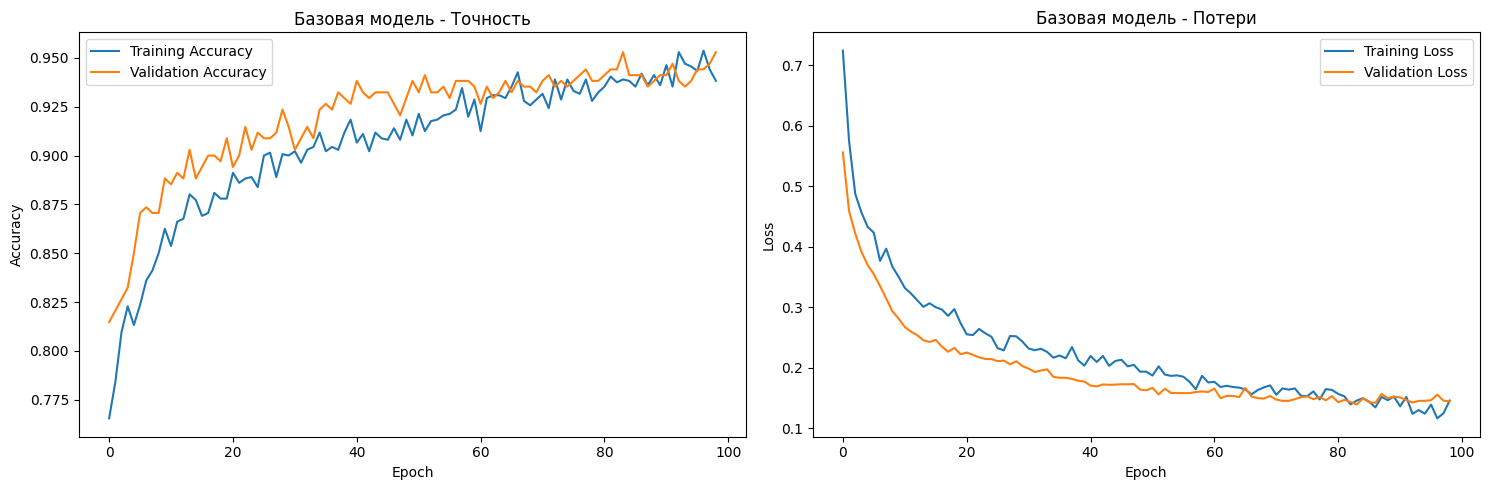

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history_base.history['accuracy'], label='Training Accuracy')
plt.plot(history_base.history['val_accuracy'], label='Validation Accuracy')
plt.title('Базовая модель - Точность')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_base.history['loss'], label='Training Loss')
plt.plot(history_base.history['val_loss'], label='Validation Loss')
plt.title('Базовая модель - Потери')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
print("АВТОЭНКОДЕРНЫЙ ПОДХОД ДЛЯ ПРЕДОБУЧЕНИЯ")
print("="*50)

pretrained_weights = []

print("1. Обучение первого автоэнкодера:")
input_data = X_train_scaled
input_dim = X_train_scaled.shape[1]

encoder1 = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(input_dim,), name='encoder1')
])

decoder1 = models.Sequential([
    layers.Dense(input_dim, activation='linear', name='decoder1')
])

autoencoder1 = models.Sequential([encoder1, decoder1])
autoencoder1.compile(optimizer='adam', loss='mse')

history1 = autoencoder1.fit(
    input_data, input_data,
    epochs=80,
    batch_size=32,
    validation_split=0.2,
    verbose=0,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

print(f"  Первый автоэнкодер обучен. Final loss: {history1.history['loss'][-1]:.4f}")
pretrained_weights.append(encoder1.layers[0].get_weights())

print("2. Обучение второго автоэнкодера:")

encoded_data1 = encoder1.predict(input_data, verbose=0)

encoder2 = models.Sequential([
    layers.Dense(32, activation='relu', input_shape=(64,), name='encoder2')
])

decoder2 = models.Sequential([
    layers.Dense(64, activation='linear', name='decoder2')
])

autoencoder2 = models.Sequential([encoder2, decoder2])
autoencoder2.compile(optimizer='adam', loss='mse')

history2 = autoencoder2.fit(
    encoded_data1, encoded_data1,
    epochs=80,
    batch_size=32,
    validation_split=0.2,
    verbose=0,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

print(f"  Второй автоэнкодер обучен. Final loss: {history2.history['loss'][-1]:.4f}")
pretrained_weights.append(encoder2.layers[0].get_weights())

print("3. Обучение третьего автоэнкодера:")

encoded_data2 = encoder2.predict(encoded_data1, verbose=0)

encoder3 = models.Sequential([
    layers.Dense(16, activation='relu', input_shape=(32,), name='encoder3')
])

decoder3 = models.Sequential([
    layers.Dense(32, activation='linear', name='decoder3')
])

autoencoder3 = models.Sequential([encoder3, decoder3])
autoencoder3.compile(optimizer='adam', loss='mse')

history3 = autoencoder3.fit(
    encoded_data2, encoded_data2,
    epochs=80,
    batch_size=32,
    validation_split=0.2,
    verbose=0,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

print(f"  Третий автоэнкодер обучен. Final loss: {history3.history['loss'][-1]:.4f}")
pretrained_weights.append(encoder3.layers[0].get_weights())

print("Все автоэнкодеры обучены!")

АВТОЭНКОДЕРНЫЙ ПОДХОД ДЛЯ ПРЕДОБУЧЕНИЯ
1. Обучение первого автоэнкодера:
  Первый автоэнкодер обучен. Final loss: 0.0029
2. Обучение второго автоэнкодера:
  Второй автоэнкодер обучен. Final loss: 0.0058
3. Обучение третьего автоэнкодера:
  Третий автоэнкодер обучен. Final loss: 0.0719
Все автоэнкодеры обучены!


In [ ]:
print("СОЗДАНИЕ ОСНОВНОЙ СЕТИ С ПРЕДОБУЧЕННЫМИ ВЕСАМИ")
print("="*50)

pretrained_model = models.Sequential()

pretrained_model.add(layers.Dense(64, activation='relu',
                                input_shape=(input_dim,),
                                name='pretrained_layer1'))
pretrained_model.add(layers.Dropout(0.3))

pretrained_model.add(layers.Dense(32, activation='relu',
                                name='pretrained_layer2'))
pretrained_model.add(layers.Dropout(0.3))

pretrained_model.add(layers.Dense(16, activation='relu',
                                name='pretrained_layer3'))
pretrained_model.add(layers.Dropout(0.2))

pretrained_model.add(layers.Dense(num_classes, activation='softmax',
                                name='output_layer'))

print("Установка предобученных весов...")
pretrained_model.layers[0].set_weights(pretrained_weights[0])
pretrained_model.layers[2].set_weights(pretrained_weights[1])
pretrained_model.layers[4].set_weights(pretrained_weights[2])

pretrained_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Архитектура модели с предобучением:")
pretrained_model.summary()

СОЗДАНИЕ ОСНОВНОЙ СЕТИ С ПРЕДОБУЧЕННЫМИ ВЕСАМИ
Установка предобученных весов...
Архитектура модели с предобучением:


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ pretrained_layer1 (Dense)       │ (None, 64)             │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pretrained_layer2 (Dense)       │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pretrained_layer3 (Dense)       │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,067 (15.89 KB)

 Trainable params: 4,067 (15.89 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print("ОБУЧЕНИЕ С УЧИТЕЛЕМ И ТОЧНАЯ НАСТРОЙКА")
print("="*50)

history_pretrained = pretrained_model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(patience=10, factor=0.5)
    ]
)

test_loss_pretrained, test_accuracy_pretrained = pretrained_model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"\nМодель с предобучением - Test Accuracy: {test_accuracy_pretrained:.4f}")

ОБУЧЕНИЕ С УЧИТЕЛЕМ И ТОЧНАЯ НАСТРОЙКА
Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.5482 - loss: 1.2538 - val_accuracy: 0.7765 - val_loss: 0.7335 - learning_rate: 0.0010
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7581 - loss: 0.7081 - val_accuracy: 0.8294 - val_loss: 0.4832 - learning_rate: 0.0010
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7729 - loss: 0.6108 - val_accuracy: 0.8500 - val_loss: 0.4001 - learning_rate: 0.0010
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8270 - loss: 0.4681 - val_accuracy: 0.8735 - val_loss: 0.3413 - learning_rate: 0.0010
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8257 - loss: 0.4479 - val_accuracy: 0.8735 - val_loss: 0.3103 - learning_rate: 0.0010
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8590 - loss: 0.3803 - val_accuracy: 0.8853 - val_loss: 0.2927 - learning_rate: 0.0010
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - a

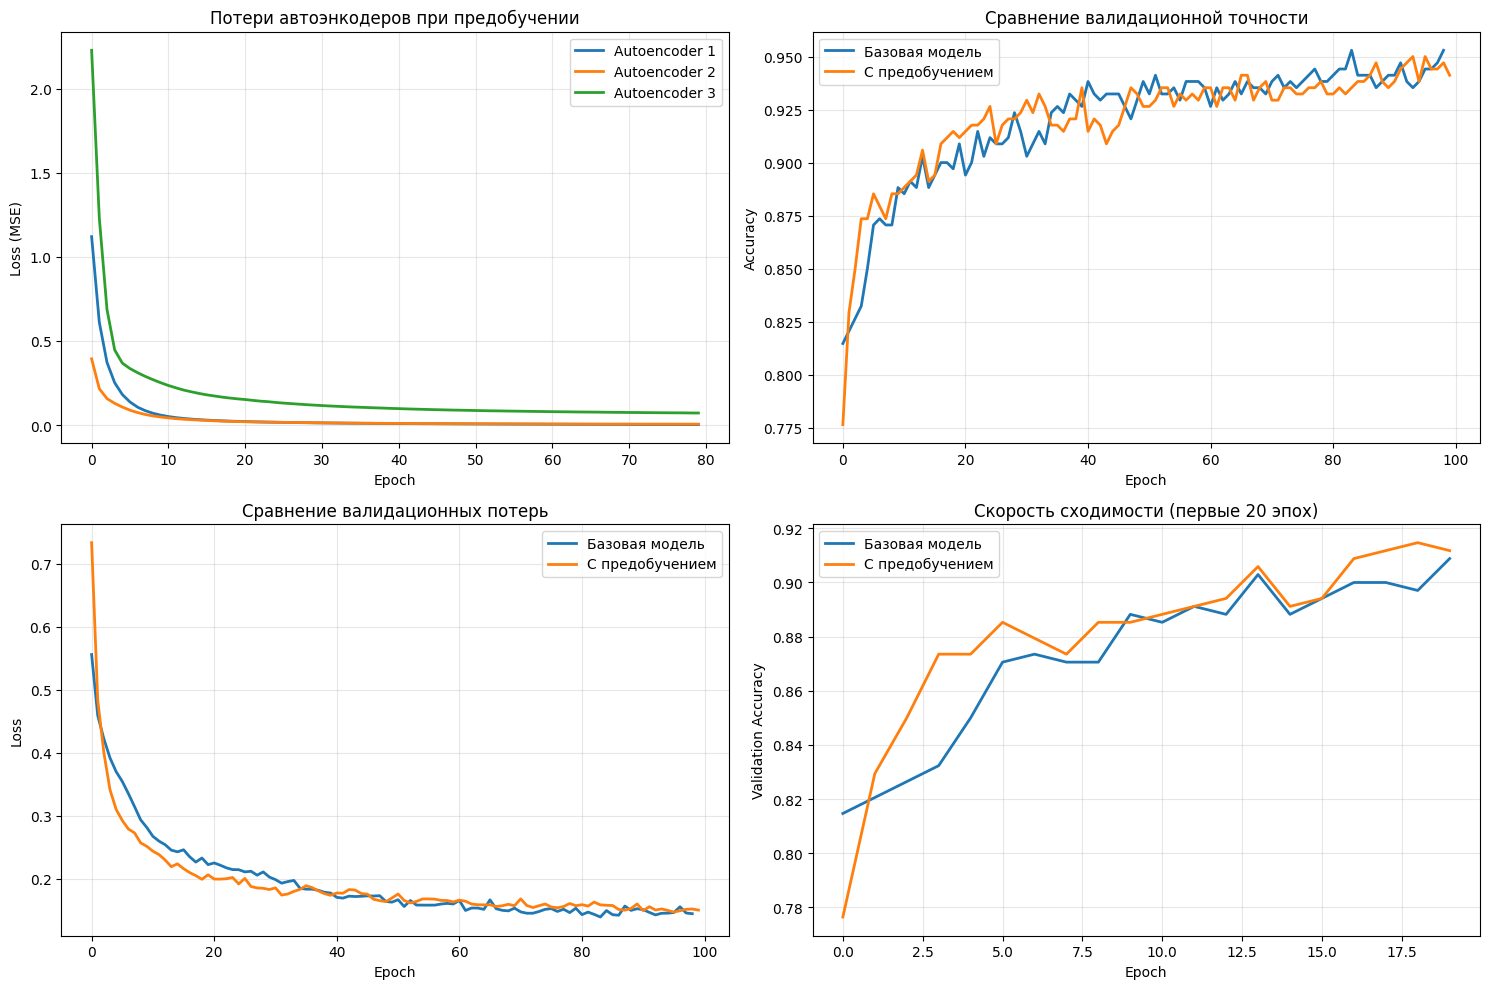

In [ ]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(history1.history['loss'], label='Autoencoder 1', linewidth=2)
plt.plot(history2.history['loss'], label='Autoencoder 2', linewidth=2)
plt.plot(history3.history['loss'], label='Autoencoder 3', linewidth=2)
plt.title('Потери автоэнкодеров при предобучении')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
plt.plot(history_base.history['val_accuracy'], label='Базовая модель', linewidth=2)
plt.plot(history_pretrained.history['val_accuracy'], label='С предобучением', linewidth=2)
plt.title('Сравнение валидационной точности')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
plt.plot(history_base.history['val_loss'], label='Базовая модель', linewidth=2)
plt.plot(history_pretrained.history['val_loss'], label='С предобучением', linewidth=2)
plt.title('Сравнение валидационных потерь')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
min_epochs = min(len(history_base.history['val_accuracy']),
                 len(history_pretrained.history['val_accuracy']), 20)
plt.plot(range(min_epochs), history_base.history['val_accuracy'][:min_epochs],
         label='Базовая модель', linewidth=2)
plt.plot(range(min_epochs), history_pretrained.history['val_accuracy'][:min_epochs],
         label='С предобучением', linewidth=2)
plt.title('Скорость сходимости (первые 20 эпох)')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()